In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import accuracy_score
import random 
import math

import time

AUTOTUNE = tf.data.AUTOTUNE


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
N_BEF_RES = 256
N_RES = 256 
# N_CLASSES = 143 
N_BATCH = 32 

In [4]:
PATH = 'C:/Users/user/Desktop/Child Skin Disease'
os.listdir('C:/Users/user/Desktop/Child Skin Disease')

['(수정) 소아피부질환 감염성.xlsx',
 'Total_Dataset',
 '~$(수정) 소아피부질환 감염성.xlsx',
 '소아피부질환 class.xlsx']

In [5]:
dataset = os.path.join(PATH, 'Total_Dataset')
dataset

'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset'

In [6]:
effection = ['Abscess',
             'Cellulitis',
             'Chicken pox (varicella)',
             'Cutaneous larva migrans',
             'Eczema herpeticum',
             'Folliculitis',
             'Furuncle',
             'Green nail syndrome',
             'Herpes simplex infection',
             'Herpes zoster',
             'Impetigo',
             'Molluscum contagiosum',
             'Paronychia',
             'Staphylococcal scalded skin syndrome',
             'Tinea capitis',
             'Tinea corporis',
             'Tinea cruris',
             'Tinea faciale', 
             'Tinea manus',
             'Tinea pedis',
             'Verruca plana',
             'Viral exanthem',
             'Wart']

In [7]:
train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files: 
               
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        # print(len(imgs))
        # print(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        # if len(imgs) > min_num and len(imgs) <= max_num: 
        key = 0 
        if f in effection:
            key = 1
            
        if key in train_dict:
            train_dict[key] = train_dict[key] + len(imgs)
        else:
            train_dict[key] = len(imgs)
            
for i in range(7, 10): 
    # files = [val for val in list(train_dict.keys())]
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files:
        
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        key = 0 
        if f in effection:
            key = 1
        
        if key in test_dict:
            test_dict[key] = test_dict[key] + len(imgs) 
        else:
            test_dict[key] = len(imgs) 
        
train_dict, test_dict

({1: 6527, 0: 51031}, {1: 6321, 0: 44854})

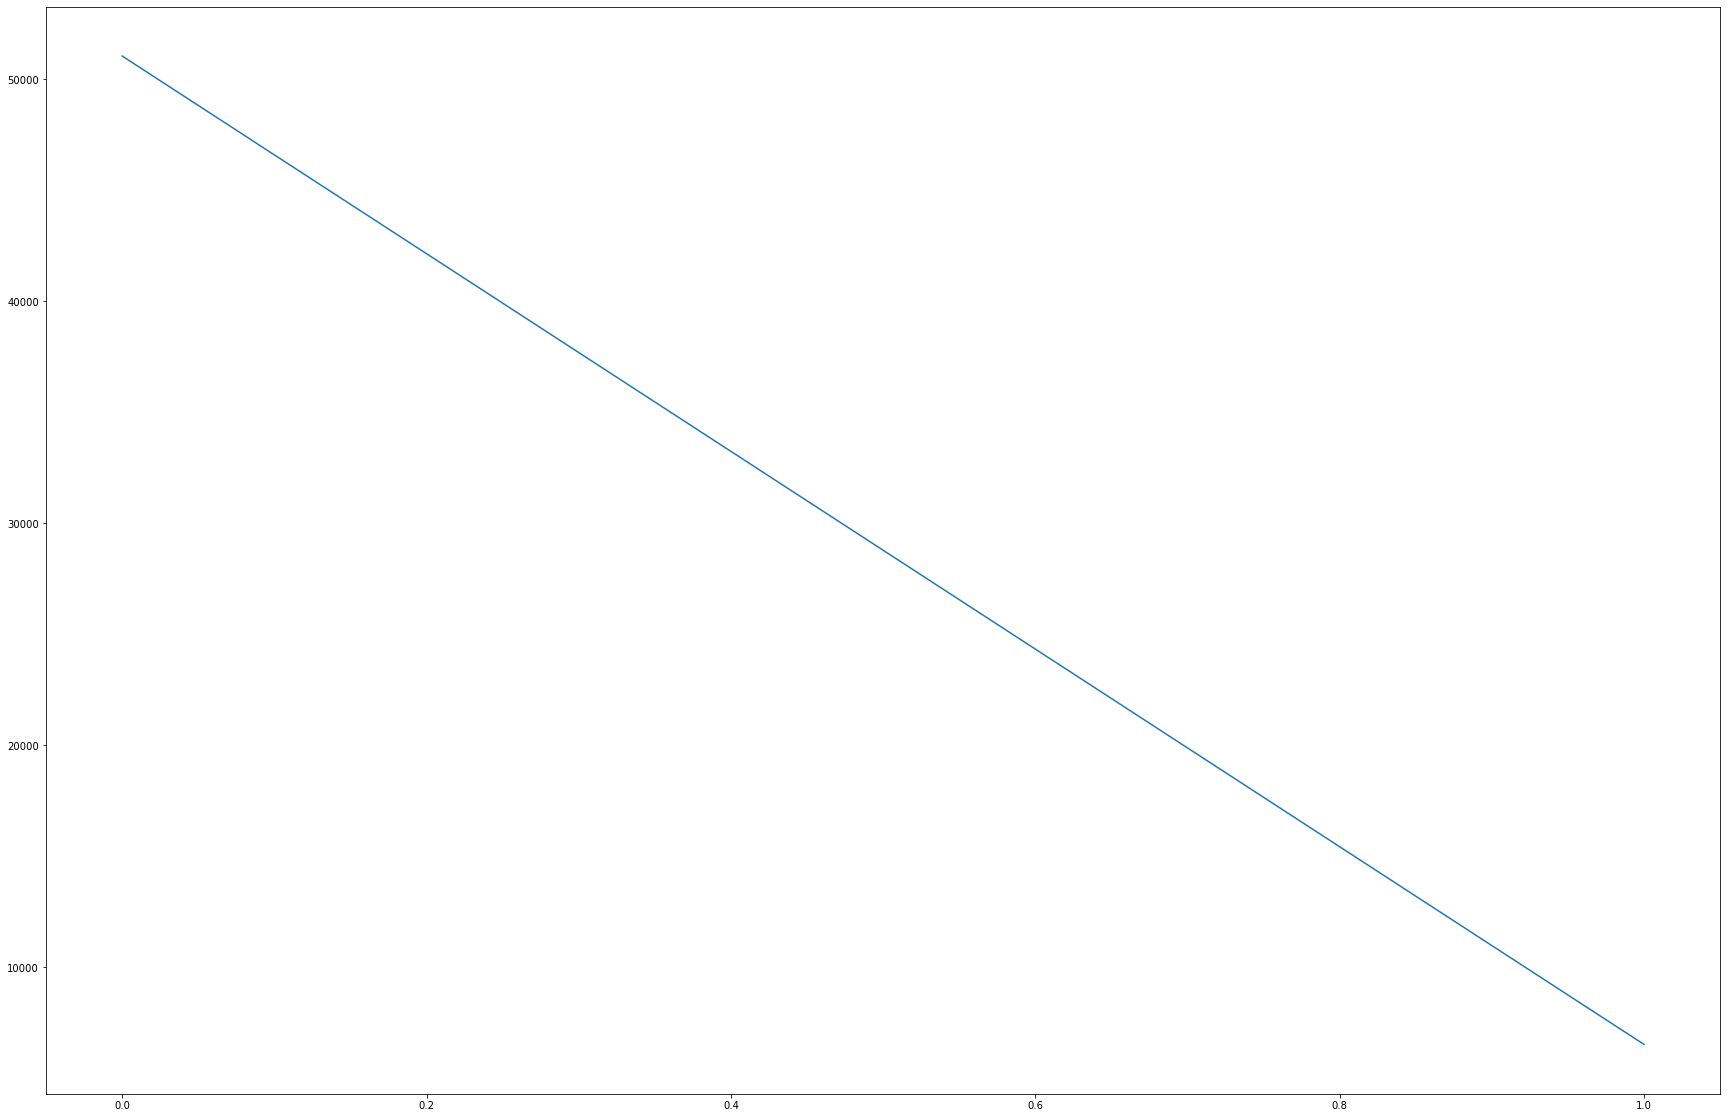

In [8]:
lists = sorted(train_dict.items())
lists

x, y = zip(*lists) 
plt.figure(figsize=(30, 20))
plt.plot(x, y)
plt.show()

In [9]:
N_CLASSES = len(train_dict)

In [10]:
train_images = [] 
test_images = []

for i in range(6):
    # for key in train_dict.keys():
    img = glob(dataset + f'/H{str(i)}/*/*.jpg')
    train_images.extend(img) 
        
for i in range(7, 10):
    # for key in train_dict.keys():
    img = glob(dataset + f'/H{str(i)}/*/*.jpg')
    test_images.extend(img) 
        
        
random.shuffle(train_images)
random.shuffle(test_images)
        
len(train_images), len(test_images)

(57558, 51175)

In [11]:
def train_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        idx = f.split('\\')[2]
        
        key = 0 
        if idx in effection:
            key = 1 
            
        lbl = tf.keras.utils.to_categorical(key, len(train_dict))

        yield (img, lbl)    
        
        # if lower than base num, should apply data augmentation
        # if base_num <= int(train_dict[idx]):
        if key == 0:

            # Btight 
            random_bright_tensor = tf.image.random_brightness(img, max_delta=128)
            random_bright_tensor = tf.clip_by_value(random_bright_tensor, 0, 255)
            random_bright_image = tf.keras.preprocessing.image.array_to_img(random_bright_tensor)
            yield (random_bright_tensor, lbl) 
    
            # rotation
            rotated_img = tf.image.rot90(img)        
            yield (rotated_img, lbl) 
            
            # curmix 
            cutmixed_img, cutmixed_lbl = cutmix(img, lbl)
            yield (cutmixed_img, cutmixed_lbl)

        

In [12]:
def test_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        
        # lbl = tf.keras.utils.to_categorical(label_to_index[f.split('\\')[1].split('/')[2]], len(train_dict))
        idx = f.split('\\')[2]
        
        key = 0 
        if idx in effection:
            key = 1 
            
        lbl = tf.keras.utils.to_categorical(key, len(train_dict))

        yield (img, lbl)    

In [13]:
def cutmix(images, labels):
    # imgs = []; labs = []
    # for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
    idx = tf.random.uniform((), 0, len(train_images), tf.int32)
    
    # random_img = 0 
    # random_lbl = 0 
    
    random_img = cv2.imread(train_images[idx], cv2.COLOR_BGR2YCR_CB)
    random_img = cv2.resize(random_img, (N_BEF_RES, N_BEF_RES))
    random_img = cv2.normalize(random_img, None, 0, 255, cv2.NORM_MINMAX)
    
    random_idx = train_images[idx].split('\\')[2]
    
    random_key = 0 
    if random_idx in effection:
        random_key = 1
        
    random_lbl = tf.keras.utils.to_categorical(random_key, N_CLASSES)

    W = N_RES
    H = N_RES
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    mid_left = images[ymin:ymax, :xmin, :]
    # mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_mid = random_img[ymin:ymax, xmin:xmax, :]
    mid_right = images[ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[:ymin, :, :]
    bottom = images[ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    # imgs.append(new_img)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin
    alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32)
    # label1 = labels[i]
    label1 = labels
    # label2 = labels[idx]
    label2 = random_lbl
    new_label = ((1-alpha)*label1 + alpha*label2)
    # labs.append(new_label)
        
    # new_imgs = tf.reshape(tf.stack(imgs), [-1, N_RES, N_RES, 3])
    # new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASSES])

    return new_img, new_label


In [14]:
def get_dropout(input_tensor, p=0.3, mc=False):
    if mc: 
        layer = Dropout(p, name='top_dropout')
        return layer(input_tensor, training=True)
    else:
        return Dropout(p, name='top_dropout')(input_tensor, training=False)

In [15]:
def create_class_weight(labels_dict, n_classes=10):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for idx, key in zip(range(N_CLASSES), keys):
        score = total / (n_classes * train_dict[key])
        class_weight[idx] = score
        
    return class_weight
        
class_weights = create_class_weight(train_dict, N_CLASSES)
class_weights

{0: 4.409223226597212, 1: 0.5639513237051988}

In [16]:
def run_expriment(model_name, train_dataset, val_dataset, optimizer='adam', trainable=False, batch_size=32, mc=False, epochs=100): 
    
    if model_name == 'efficient':
        base_model = keras.applications.EfficientNetB7(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = trainable
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.GlobalAveragePooling2D()(x) 
        x = get_dropout(x, mc)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        
    # VGG16 
    else:
        base_model = keras.applications.VGG16(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = True
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.Flatten(name = "avg_pool")(x) 
        x = keras.layers.Dense(512, activation='relu')(x)
        x = get_dropout(x, mc)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        

    sv = [tf.keras.callbacks.ModelCheckpoint(os.path.join(f'models/{model_name}_mc-{mc}_bs-{batch_size}_{time.strftime("%Y%m%d-%H%M%S")}.h5'), 
                                             monitor='val_accuracy', 
                                             verbose=0, 
                                             save_best_only=True,
                                             save_weights_only=True, 
                                             mode='max', 
                                             save_freq='epoch'), 
          tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                           patience = 4, 
                                           min_delta = 0.01)
          ]

    
    LR = 0.0001
    steps_per_epoch = len(train_images) // batch_size
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LR, steps_per_epoch*30, 0.1, True)
    
    # sgd = tf.keras.optimizers.SGD(0.01)
    # moving_avg_sgd = tfa.optimizers.MovingAverage(sgd)
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr_schedule)
    else:
        optimizer = tf.keras.optimizers.SGD(lr_schedule)
    
    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                  optimizer = optimizer,
                  metrics=['accuracy'])
    
    hist = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = epochs,
                    class_weight=class_weights, 
                    verbose = 1,
                    shuffle = True,
                    # callbacks = [sv]
                    )
    
    # histories.append(hist)
    
    return model, hist
    

In [17]:
train_dataset = tf.data.Dataset.from_generator(train_skin_data, 
                                               output_types=(tf.float64, tf.float32), 
                                               output_shapes=(tf.TensorShape([N_RES, N_RES, 3]), tf.TensorShape([N_CLASSES])),
                                               args=[train_images])

test_dataset = tf.data.Dataset.from_generator(test_skin_data, 
                                              output_types=(tf.float64, tf.float32), 
                                              output_shapes=(tf.TensorShape([N_RES, N_RES, 3]), tf.TensorShape([N_CLASSES])),
                                              args=[test_images])


In [18]:
split_size = int(len(train_images) * 0.2)
split_train_dataset = train_dataset.skip(split_size)
split_val_dataset = train_dataset.take(split_size)

split_train_dataset = split_train_dataset.batch(32).prefetch(AUTOTUNE)
split_val_dataset = split_val_dataset.batch(32).prefetch(AUTOTUNE)

In [83]:
with tf.device('/device:GPU:0'):
    model, hist = run_expriment('efficient', split_train_dataset, split_val_dataset, optimizer='adam', batch_size=32, trainable=False, epochs=10)

Epoch 1/10
6224/6224 [==============================] - 2636s 407ms/step - loss: 0.0420 - accuracy: 0.9649 - val_loss: 0.0525 - val_accuracy: 0.9645
Epoch 2/10
6224/6224 [==============================] - 2649s 410ms/step - loss: 0.0360 - accuracy: 0.9650 - val_loss: 0.0507 - val_accuracy: 0.9634
Epoch 3/10
6224/6224 [==============================] - 2638s 409ms/step - loss: 0.0352 - accuracy: 0.9653 - val_loss: 0.0512 - val_accuracy: 0.9632
Epoch 4/10
6224/6224 [==============================] - 2613s 405ms/step - loss: 0.0348 - accuracy: 0.9652 - val_loss: 0.0504 - val_accuracy: 0.9626
Epoch 5/10
6224/6224 [==============================] - 2598s 402ms/step - loss: 0.0348 - accuracy: 0.9650 - val_loss: 0.0503 - val_accuracy: 0.9628
Epoch 6/10
6224/6224 [==============================] - 2595s 402ms/step - loss: 0.0341 - accuracy: 0.9652 - val_loss: 0.0503 - val_accuracy: 0.9631
Epoch 7/10
6224/6224 [==============================] - 2590s 401ms/step - loss: 0.0342 - accuracy: 0.9651

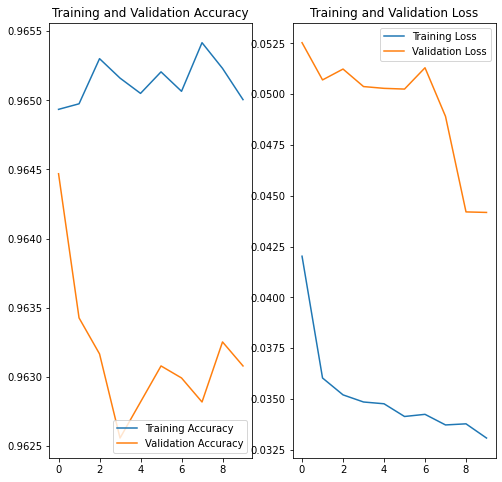

In [84]:
# hist
# for hist in histories:
plt.figure(1, figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 

In [87]:
test_dataset = test_dataset.batch(32).prefetch(AUTOTUNE)

model.evaluate(test_dataset)

1600/1600 [==============================] - 291s 181ms/step - loss: 0.1810 - accuracy: 0.8767


[0.18101753294467926, 0.8766780495643616]

In [19]:
with tf.device('/device:GPU:0'):
    model, hist = run_expriment('efficient', split_train_dataset, split_val_dataset, optimizer='adam', batch_size=32, trainable=True, epochs=10)


Epoch 1/10


NotFoundError: Graph execution error:

Detected at node 'model/efficientnetb7/block7b_expand_conv/Conv2D' defined at (most recent call last):
    File "c:\ProgramData\Miniconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Miniconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Miniconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\ProgramData\Miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\ProgramData\Miniconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_7600\1024984301.py", line 2, in <cell line: 1>
      model, hist = run_expriment('efficient', split_train_dataset, split_val_dataset, optimizer='adam', batch_size=32, trainable=True, epochs=10)
    File "C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_7600\4148899588.py", line 57, in run_expriment
      hist = model.fit(train_dataset,
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/efficientnetb7/block7b_expand_conv/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 31850512 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 26623488 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 22020096 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 22020096 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Allocating 5719326720 bytes exceeds the memory limit of 4294967296 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Allocating 5719326720 bytes exceeds the memory limit of 4294967296 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 506986496 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 506986496 bytes.
	 [[{{node model/efficientnetb7/block7b_expand_conv/Conv2D}}]] [Op:__inference_train_function_65712]

: 

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()    

In [ ]:
test_dataset = test_dataset.batch(32).prefetch(AUTOTUNE)

model.evaluate(test_dataset)